## *Data Loading*

In [3]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
import warnings
warnings.filterwarnings('ignore')

house_data = datasets.fetch_california_housing()
df = pd.DataFrame(house_data.data, columns=house_data.feature_names)
df['Price'] = house_data.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## *EDA*

In [4]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Price
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [5]:
df.duplicated().sum(), df.isnull().sum().sum()

(np.int64(0), np.int64(0))

No duplicated samples, no missing values..

In [6]:
def check_outliers(df):
    cols = df.columns
    for col in cols:
        Q1 = np.percentile(df[col], 25, method='midpoint')
        Q3 = np.percentile(df[col], 75, method='midpoint')
        IQR = Q3 - Q1
        lower_term = Q1 - 1.5*IQR
        upper_term = Q3 + 1.5*IQR
        Outliers = df[(df[col]<lower_term) | (df[col]>upper_term)]
        print(f'Outlier values of {col}: {Outliers.shape[0]}')
        print('-'*35)

check_outliers(df)

Outlier values of MedInc: 680
-----------------------------------
Outlier values of HouseAge: 0
-----------------------------------
Outlier values of AveRooms: 511
-----------------------------------
Outlier values of AveBedrms: 1424
-----------------------------------
Outlier values of Population: 1196
-----------------------------------
Outlier values of AveOccup: 711
-----------------------------------
Outlier values of Latitude: 0
-----------------------------------
Outlier values of Longitude: 0
-----------------------------------
Outlier values of Price: 1071
-----------------------------------


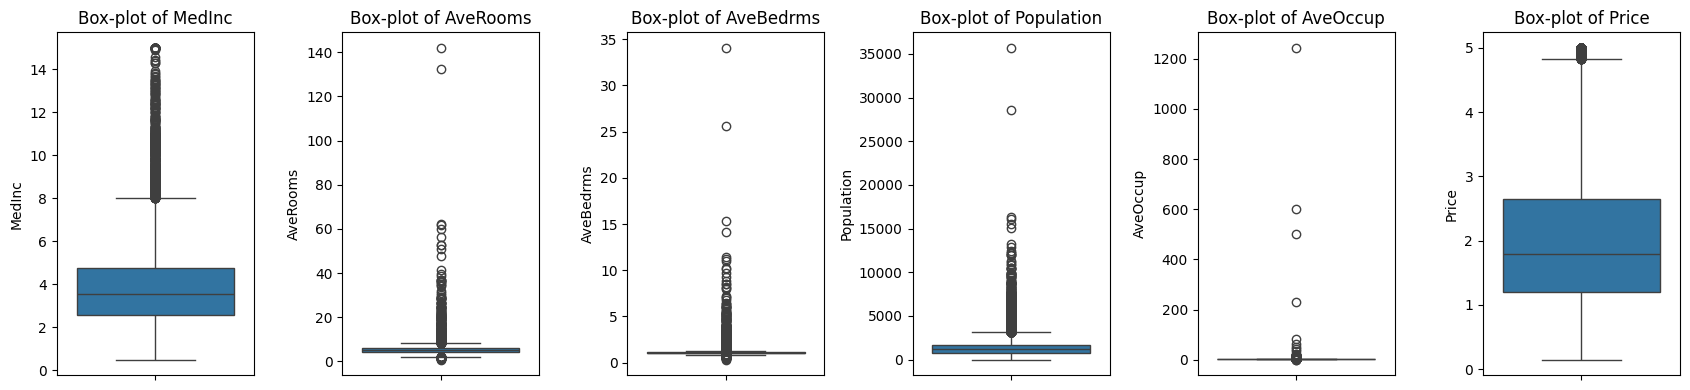

In [7]:
to_boxplot = ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Price']

fig, ax = plt.subplots(1, len(to_boxplot), figsize=(17, 4))
for i, col in enumerate(to_boxplot):
    sns.boxplot(y=df[col], ax=ax[i])
    ax[i].set_title('Box-plot of '+col)
    
plt.tight_layout()
plt.show()

Must normalize features which having an outliers...

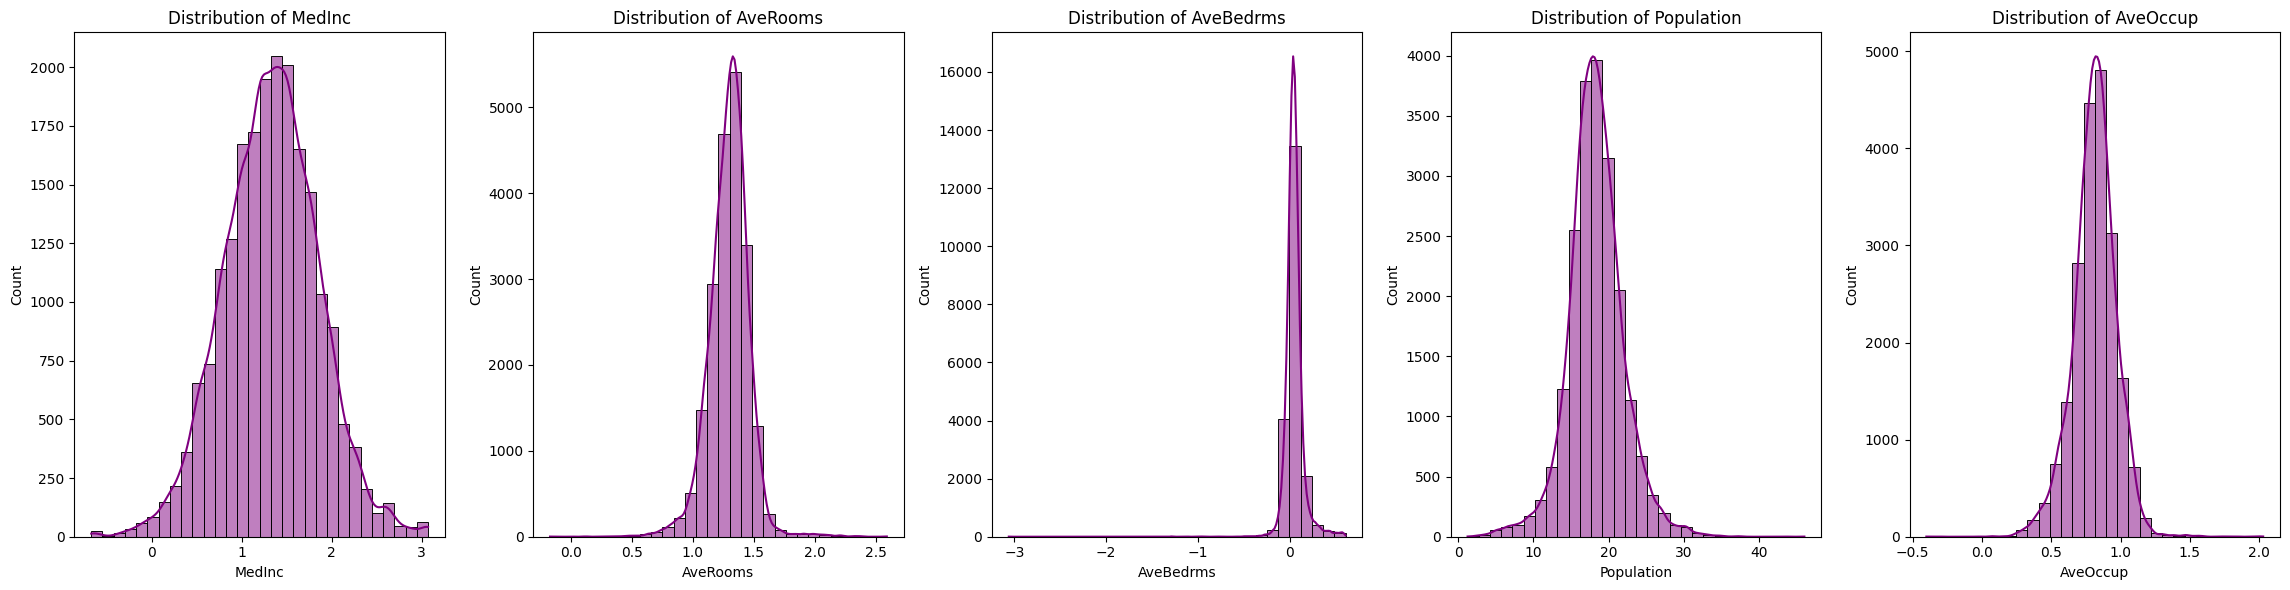

In [8]:
import scipy

to_normalization = to_boxplot.copy()
to_normalization.remove('Price')

fig, ax = plt.subplots(1, len(to_normalization), figsize=(23, 6))
for i, col in enumerate(to_normalization):
    df[col], trans_coef = scipy.stats.boxcox(df[col])
    sns.histplot(df, x=df[col], bins=30, kde=True, ax=ax[i], color='purple')
    ax[i].set_title('Distribution of '+col)
    
plt.tight_layout()
plt.show()

Now, data nearest to normally distribution..

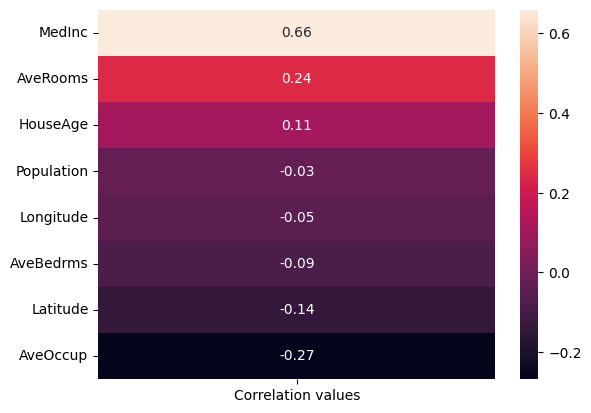

In [9]:
# Check Correelation between target and features..

features = df.drop(['Price'], axis=1)
target = df['Price']

corrs = features.corrwith(target).sort_values(ascending=False)
corrs_df = pd.DataFrame(corrs, columns=['Correlation values'], index=corrs.index)
sns.heatmap(corrs_df, annot=True, fmt='.2f')
plt.show()

## *Data Splitting*

In [10]:
from sklearn.model_selection import train_test_split

X = features.copy()
y = target.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

## *Linear Regression*

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

scaler = MinMaxScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_sc, y_train)

y_pred_lr = lr.predict(X_test_sc)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2 = r2_score(y_test, y_pred_lr)
print(f'RMSE of Linear Regression: {rmse}')
print(f'R Score of Linear Regression: {r2:0.4f}')

RMSE of Linear Regression: 0.703147578755505
R Score of Linear Regression: 0.6233


## *Random Forest Regressor*

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth=7, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2 = r2_score(y_test, y_pred_rf)
print(f'RMSE of Random Forest Regressor: {rmse}')
print(f'R Score of Random Forest Regressor: {r2:0.4f}')

RMSE of Random Forest Regressor: 0.6063855164135867
R Score of Random Forest Regressor: 0.7199


## *XGradien Boost Regressor*

In [13]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2 = r2_score(y_test, y_pred_xgb)
print(f'RMSE of XGB Regressor: {rmse}')
print(f'R Score of XGB Regressor: {r2:0.4f}')

RMSE of XGB Regressor: 0.4602420428781616
R Score of XGB Regressor: 0.8386


In [14]:
# Hyperparameter Tuning of XGBR...

from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 150, 200],
               'learning_rate': [0.01, 0.1, 1],
               'max_depth': [6, 8, 10],
               'subsample': [0.6, 0.8, 1]
}
grid = GridSearchCV(estimator=xgb, param_grid=param_grid,
                          cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print(f'Best score of model (R²): {grid.best_score_:0.4f}')
print(f'Best parameters: {grid.best_params_}')

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best score of model (R²): 0.8358
Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}


In [15]:
# Assign best parameters..

best_xgb = XGBRegressor(**grid.best_params_, random_state=42)
best_xgb.fit(X_train, y_train)

y_pred = best_xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'RMSE of best XGB Regressor: {rmse}')
print(f'R Score of best XGB Regressor: {r2:0.4f}')

RMSE of best XGB Regressor: 0.45410828652582524
R Score of best XGB Regressor: 0.8429


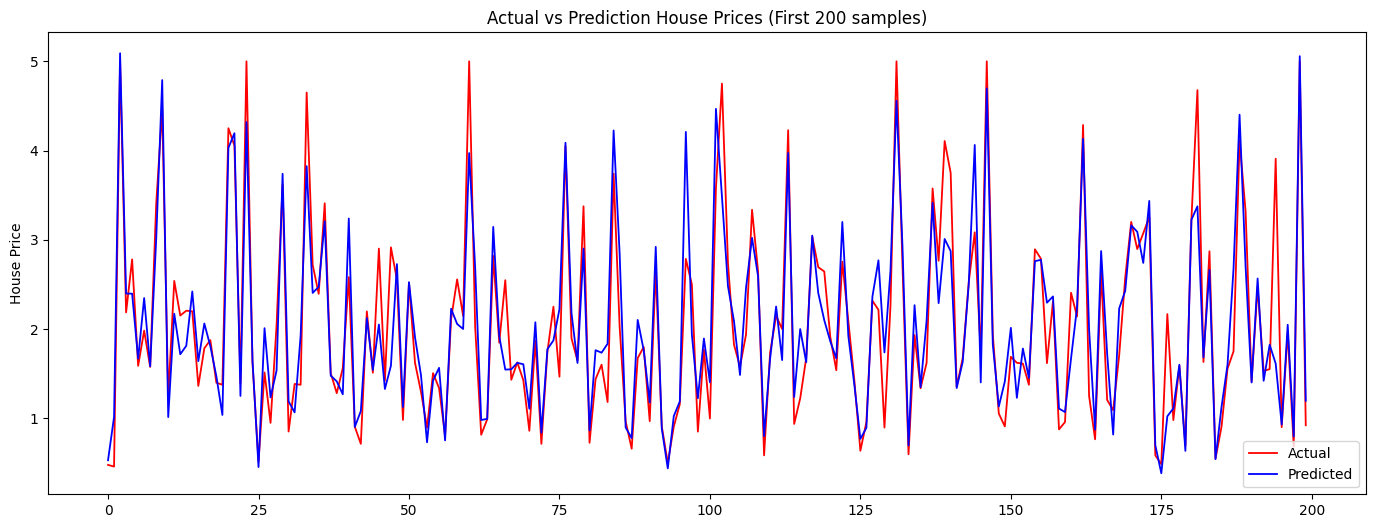

In [16]:
plt.figure(figsize=(17, 6))
plt.plot(y_test.ravel()[:200], color='red', lw=1.3, label='Actual')
plt.plot(y_pred.ravel()[:200], color='blue', lw=1.3, label='Predicted')
plt.title('Actual vs Prediction House Prices (First 200 samples)')
plt.ylabel('House Price')
plt.legend()
plt.show()

## *Conlusion*

1. **Best Model**: Extreme Gradient Boosting Regressor with score ~84.3% of R²
2. **Important Feature**: Median Income of population

*Data have a **large noise** which causes linear regression doesn't fit the data with a high performance.*



🌐**Connections**

**📧email: salahmostafaa21@gmail.com  |  linkedin: www.linkedin.com/in/salah-mostafa**